In [84]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, BatchNormalization, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from keras import optimizers
import math

In [2]:
df = pd.read_csv('./Glucose_Train_Set.csv')

val_df = pd.read_csv('./Glucose_Validation_Set_Complete.csv')[['SID','Day','DailyTI_Index','Value']]
val_missing = pd.read_csv('./Glucose_Validation_Set.csv')[['SID','Day','DailyTI_Index','Value']]

In [3]:
missing_data = pd.merge(val_df, val_missing, on = ['SID','Day','DailyTI_Index'], how = 'left')
missing_data.columns = ['SID','Day','DailyTI_Index','Value_complete', 'Value_missing']

In [4]:
train_data = df.sort_values(by=['DailyTI_Index']).groupby(['SID', 'Day'])['Value'].apply(list).reset_index()
validation_missing = missing_data.sort_values(by=['DailyTI_Index']).groupby(['SID', 'Day'])['Value_missing'].apply(list).reset_index()
validation_complete = missing_data.sort_values(by=['DailyTI_Index']).groupby(['SID', 'Day'])['Value_complete'].apply(list).reset_index()


In [6]:
y_val = np.array(validation_missing['Value_missing'].to_list())

In [7]:
X_train = np.array(train_data['Value'].to_list())

In [53]:
## Normalize the data
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Reshaping X_train for the LSTM model, LSTM expects input to be in [samples, time steps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

# Define a Seq2Seq LSTM model best was 50 and 50
model = Sequential([
    LSTM(100, activation='sigmoid', input_shape=(288, 1), return_sequences=False), # set to false for seq2seq
    RepeatVector(288),  # Determines the length of the output sequence
    LSTM(100, activation='sigmoid', return_sequences=True),
    TimeDistributed(Dense(1))
])

optimizer = optimizers.Adam(learning_rate = 0.001, clipvalue=0.5) # for seq2seq clipvalue=0.5
model.compile(optimizer=optimizer, loss='mse')

# Train the model
model.fit(X_train_reshaped, X_train_reshaped, epochs=20, batch_size=64, verbose=1)

Epoch 1/20
1107/1107 [==============================] - 401s 361ms/step - loss: 0.7065
Epoch 2/20
1107/1107 [==============================] - 811s 733ms/step - loss: 0.6577
Epoch 3/20
1107/1107 [==============================] - 418s 378ms/step - loss: 0.5919
Epoch 4/20
1107/1107 [==============================] - 1344s 1s/step - loss: 0.5380
Epoch 5/20
1107/1107 [==============================] - 407s 368ms/step - loss: 0.5159
Epoch 6/20
1107/1107 [==============================] - 416s 375ms/step - loss: 0.4517
Epoch 7/20
1107/1107 [==============================] - 426s 385ms/step - loss: 0.4144
Epoch 8/20
1107/1107 [==============================] - 460s 415ms/step - loss: 0.3817
Epoch 9/20
1107/1107 [==============================] - 500s 452ms/step - loss: 0.3480
Epoch 10/20
1107/1107 [==============================] - 433s 391ms/step - loss: 0.3284
Epoch 11/20
1107/1107 [==============================] - 446s 403ms/step - loss: 0.3074
Epoch 12/20
1107/1107 [====================

In [54]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 100)               40800     
                                                                 
 repeat_vector_13 (RepeatVec  (None, 288, 100)         0         
 tor)                                                            
                                                                 
 lstm_32 (LSTM)              (None, 288, 100)          80400     
                                                                 
 time_distributed_19 (TimeDi  (None, 288, 1)           101       
 stributed)                                                      
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Prepare the test sequence
test_sequences = y_val
# Handle NaNs for normalization (simple imputation, consider a better method for your use case)
test_sequences_imputed = np.array([np.where(np.isnan(seq), np.nanmean(seq), seq) for seq in test_sequences])

# Standardize the test sequences
test_sequences_scaled = scaler.transform(test_sequences_imputed)

# Reshape for the model
test_sequences_scaled_reshaped = test_sequences_scaled.reshape((test_sequences_scaled.shape[0], 288, 1))

# Predicting the sequences
predicted_sequences_scaled = model.predict(test_sequences_scaled_reshaped)

# Inverse transform to original scale
predicted_sequences = scaler.inverse_transform(predicted_sequences_scaled.reshape(test_sequences_scaled.shape[0], 288))


317/317 [==============================] - 21s 66ms/step


In [88]:
predictions = []

# Iterate through each row in the array and append it as a list to data_for_df
for row in predicted_sequences:
    predictions.append(row)  # Each row becomes a list that is then wrapped in another list to represent a single cell in the DataFrame


In [89]:
validation_missing['Value_prediction_seq'] = predictions

In [90]:
preds_vs_true = pd.merge(validation_missing, validation_complete)

In [91]:
def find_nan_indices(lst):
    """
    Returns a list of indices where the item in the list is NaN.
    
    :param lst: List to check for NaN values.
    :return: List of indices with NaN values.
    """
    return [i for i, x in enumerate(lst) if isinstance(x, float) and np.isnan(x)]

# Now, apply the function to the 'Value_missing' column
preds_vs_true['Missing_Indexes'] = preds_vs_true['Value_missing'].apply(find_nan_indices)

In [92]:
RMSEs =[]
missing_count = []
predicted_values = []
true_values = []

for j in range(len(preds_vs_true)):
    check_list = []
    count = 0
    pred_vals = []
    true_val = []
    for i in find_nan_indices(preds_vs_true['Value_missing'][j]):
        check_list.append((preds_vs_true['Value_complete'][j][i] - preds_vs_true['Value_prediction_seq'][j][i])**2)
        count += 1
        pred_vals.append(preds_vs_true['Value_prediction_seq'][j][i])
        true_val.append(preds_vs_true['Value_complete'][j][i])
    
    RMSEs.append(np.mean(check_list)**(1/2))
    missing_count.append(count)
    predicted_values.append(pred_vals)
    true_values.append(true_val)

In [93]:
preds_vs_true['Avg RMSE'] = RMSEs
preds_vs_true['missing_count'] = missing_count
preds_vs_true['Predicted_Values'] = predicted_values
preds_vs_true['True_Values'] = true_values

In [94]:
preds_vs_true['offset_start'] = preds_vs_true['Missing_Indexes'].apply(np.array).apply(min)-1
preds_vs_true['offset_value'] = preds_vs_true.apply(lambda row: row['Value_missing'][row['offset_start']], axis=1) - \
                                    preds_vs_true.apply(lambda row: row['Value_prediction_seq'][row['offset_start']], axis=1)



In [95]:
# Add the single float to each element of the lists
preds_vs_true['Offset_Predicted_Values'] = preds_vs_true.apply(lambda row: [x + row['offset_value'] for x in row['Predicted_Values']], axis=1)

In [98]:
# Display the DataFrame
preds_vs_true['Offset_Sq_Error'] = preds_vs_true.apply(lambda row: [(a - b)**2 for a, b in zip(row['True_Values'], row['Offset_Predicted_Values'])], axis=1)

In [99]:
preds_vs_true['Offset_RMSE']= preds_vs_true['Offset_Sq_Error'].apply(np.array).apply(np.mean).apply(math.sqrt)

In [100]:
# Display the DataFrame
preds_vs_true['Offset_Sq_Error'] = preds_vs_true.apply(lambda row: [(a - b)**2 for a, b in zip(row['True_Values'], row['Offset_Predicted_Values'])], axis=1)

In [101]:
preds_vs_true.groupby('missing_count')['Offset_RMSE'].mean()

missing_count
4      9.383418
5     11.243786
6     12.784631
7     14.479215
8     15.429136
9     15.894391
10    18.445902
11    18.779671
12    18.640696
24    29.606646
48    44.273449
96    58.366612
Name: Offset_RMSE, dtype: float64

In [102]:
preds_vs_true.groupby('missing_count')['Avg RMSE'].mean()

missing_count
4     24.648984
5     26.677280
6     25.866117
7     27.696496
8     27.221079
9     27.858056
10    27.749505
11    29.832824
12    30.823165
24    37.800255
48    48.002296
96    57.784217
Name: Avg RMSE, dtype: float64

In [103]:
preds_vs_true

,SID,Day,Value_missing,Value_prediction,Value_prediction_seq,Value_complete,Missing_Indexes,Avg RMSE,missing_count,Predicted_Values,True_Values,offset_start,offset_value,Offset_Predicted_Values,Offset_Sq_Error,Offset_RMSE
0,CITY-1,2,"[306.0, 301.0, 301.0, 301.0, 300.0, 306.0, 312...","[208.3378, 229.7558, 240.91525, 246.69421, 251...","[208.3378, 229.7558, 240.91525, 246.69421, 251...","[306.0, 301.0, 301.0, 301.0, 300.0, 306.0, 312...","[30, 31, 32, 33]",22.841109,4,"[244.44739, 243.7713, 243.12221, 242.51166]","[268.0, 271.0, 255.0, 268.0]",29,20.892548,"[265.3399353027344, 264.6638488769531, 264.014...","[7.075944193638861, 40.146811054088175, 81.265...",6.115756
1,CITY-1,11,"[248.0, 251.0, 251.0, 254.0, 257.0, 262.0, 268...","[198.85614, 218.24315, 229.18866, 235.49316, 2...","[198.85614, 218.24315, 229.18866, 235.49316, 2...","[248.0, 251.0, 251.0, 254.0, 257.0, 262.0, 268...","[77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 8...",181.114921,96,"[277.39728, 273.3065, 269.09702, 264.77448, 26...","[370.0, 371.0, 374.0, 376.0, 379.0, 380.0, 353...",76,85.618134,"[363.0154113769531, 358.92462158203125, 354.71...","[48.78447823319584, 145.81476393714547, 371.90...",101.466179
2,CITY-1,207,"[206.0, 204.0, 202.0, 202.0, 204.0, 208.0, 211...","[181.06387, 184.20038, 180.99013, 175.59688, 1...","[181.06387, 184.20038, 180.99013, 175.59688, 1...","[206.0, 204.0, 202.0, 202.0, 204.0, 208.0, 211...","[266, 267, 268, 269, 270, 271, 272]",25.126301,7,"[157.27106, 156.35637, 155.47372, 154.60184, 1...","[185.0, 186.0, 184.0, 178.0, 175.0, 174.0, 175.0]",265,23.804962,"[181.07601928710938, 180.1613311767578, 179.27...","[15.397624635137618, 34.09005362750031, 22.290...",3.536233
3,CITY-1,282,"[266.0, 270.0, 265.0, 261.0, 258.0, 257.0, 253...","[217.15889, 240.95534, 251.59715, 256.25998, 2...","[217.15889, 240.95534, 251.59715, 256.25998, 2...","[266.0, 270.0, 265.0, 261.0, 258.0, 257.0, 253...","[108, 109, 110, 111, 112, 113, 114, 115, 116, ...",107.991762,48,"[181.1888, 181.97937, 182.76845, 183.59001, 18...","[88.0, 86.0, 83.0, 81.0, 80.0, 82.0, 85.0, 87....",107,-89.377869,"[91.81092834472656, 92.60150146484375, 93.3905...","[14.523174848640338, 43.57982159033418, 107.96...",19.865159
4,CITY-1,283,"[234.0, 223.0, 214.0, 206.0, 195.0, 180.0, 167...","[181.03581, 183.86772, 179.55746, 173.00145, 1...","[181.03581, 183.86772, 179.55746, 173.00145, 1...","[234.0, 223.0, 214.0, 206.0, 195.0, 180.0, 167...","[108, 109, 110, 111, 112, 113, 114, 115, 116, ...",23.218683,24,"[233.3754, 235.01768, 236.49466, 237.85791, 23...","[204.0, 203.0, 206.0, 206.0, 204.0, 205.0, 208...",107,-29.546280,"[203.82911682128906, 205.47140502929688, 206.9...","[0.029201060766354203, 6.107842818833888, 0.89...",11.049530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10113,WISDM-98,174,"[91.0, 92.0, 92.0, 93.0, 94.0, 95.0, 94.0, 94....","[140.2449, 125.1096, 113.63342, 104.69604, 100...","[140.2449, 125.1096, 113.63342, 104.69604, 100...","[91.0, 92.0, 92.0, 93.0, 94.0, 95.0, 94.0, 94....","[26, 27, 28, 29, 30, 31, 32, 33, 34]",18.202960,9,"[102.973236, 103.08213, 103.14162, 103.18362, ...","[118.0, 120.0, 122.0, 123.0, 123.0, 123.0, 122...",25,11.163963,"[114.13719940185547, 114.24609375, 114.3055801...","[14.921228461025748, 33.10743713378906, 59.204...",7.146749
10114,WISDM-98,183,"[158.0, 163.0, 153.0, 122.0, 125.0, 126.0, 148...","[163.26683, 160.00116, 153.71292, 146.79503, 1...","[163.26683, 160.00116, 153.71292, 146.79503, 1...","[158.0, 163.0, 153.0, 122.0, 125.0, 126.0, 148...","[244, 245, 246, 247, 248, 249]",26.318861,6,"[93.70651, 94.58452, 95.46723, 96.42583, 97.43...","[68.0, 58.0, 64.0, 69.0, 80.0, 88.0]",243,-21.892769,"[71.8137435913086, 72.6917495727539, 73.574462...","[14.54464018024737, 215.8475055085146, 91.6703...",9.148256
10115,WISDM-98,185,"[183.0, 193.0, 194.0, 192.0, 195.0, 195.0, 199...","[184.62463, 198.11377, 203.4904, 205.02841, 20...","[184.62463, 198.11377, 203.4904, 205.02841, 20...","[183.0, 193.0, 194.0, 1

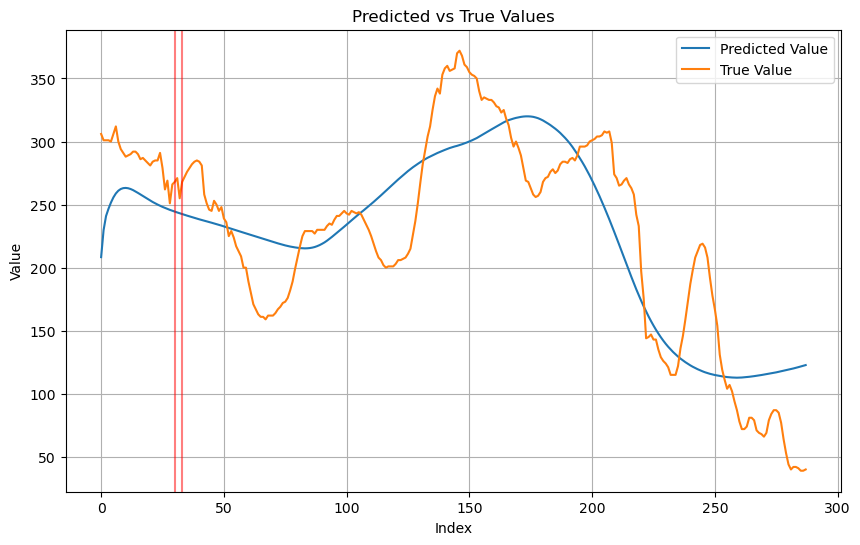

In [105]:
val_point = 0

compare_dataframe = pd.DataFrame({'True Value':preds_vs_true['Value_complete'][val_point].copy(), 'Predicted Value':preds_vs_true['Value_prediction'][val_point].copy()})

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(compare_dataframe.index, compare_dataframe['Predicted Value'], label='Predicted Value')
plt.plot(compare_dataframe.index, compare_dataframe['True Value'], label='True Value')

plt.axvline(x=np.array(preds_vs_true['Missing_Indexes'][val_point]).min(), color='red', alpha=0.5)
plt.axvline(x=np.array(preds_vs_true['Missing_Indexes'][val_point]).max(), color='red', alpha=0.5)

plt.title('Predicted vs True Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [106]:
preds_vs_true.to_csv('Seq2Seq_LSTM_100nodes.csv', index = False)